In [17]:
import pandas as pd

In [18]:
train_intent = pd.read_csv("../assistant/data/common_intents.csv")
train_intent

,messages,intent
0,What's the weather like today?,Negative
1,What's the price of gold today?,Negative
2,I want to book a flight ticket.,Negative
3,Can you tell me the current exchange rate?,Negative
4,How do I cook pho?,Negative
...,...,...
1637,Enumerate your range of capabilities.,Ask Features
1638,Describe what kind of tasks you can handle.,Ask Features
1639,Detail the functions you excel in.,Ask Features
1640,Explain your range of assistance.,Ask Features


In [19]:
train_intent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   messages  1642 non-null   object
 1   intent    1642 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [20]:
# Xem số lượng mỗi intent
intent_counts = train_intent['intent'].value_counts()
print(intent_counts)


Negative             532
Greet                206
Description          199
Course Search        196
Open Landing Page    184
Ask Features         125
Bot Challenge        100
Ask Name             100
Name: intent, dtype: int64


In [21]:
train_intent = train_intent.sample(frac=1).reset_index(drop=True)
train_intent

,messages,intent
0,"Hi, is this a digital assistant?",Bot Challenge
1,What is the platform's refund policy?,Negative
2,Can you recommend resources for understanding ...,Negative
3,Can you list your capabilities?,Ask Features
4,How can I enroll in online courses?,Course Search
...,...,...
1637,Could you describe the skills covered in the C...,Description
1638,How do I access live chat support?,Negative
1639,How do I register for a library card?,Negative
1640,What are the data analysis tools used in data ...,Course Search


# Init model

In [25]:
import pandas as pd

In [26]:
import numpy as np 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, RobertaModel, TrainingArguments, Trainer

In [27]:
# define RoBERTa model
roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
roberta_model = RobertaModel.from_pretrained("FacebookAI/roberta-base")


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
train_intent = pd.read_csv("../assistant/data/common_intents.csv")
train_intent = train_intent.sample(frac=1).reset_index(drop=True)
train_intent.to_csv("../assistant/data/common_intents.csv", index=False)

In [29]:
intents = {
    'Description': 0,
    'Course Search': 1,
    'Open Landing Page': 2,
    'Negative': 3,
    'Bot Challenge': 4,
    'Greet': 5,
    'Ask Features': 6,
    'Ask Name': 7
}

for item in train_intent["intent"]:
    if item not in intents:
        print(f"intent value '{item}' not found in intents dictionary.")

In [30]:
train_data, test_data = train_test_split(train_intent, test_size=0.2, random_state=42)

def prepare_input_data(data):
    encoded_data = roberta_tokenizer(data["messages"].tolist(), padding=True, truncation=True, return_tensors="pt")
    return encoded_data

In [31]:
train_inputs = prepare_input_data(train_data)
test_inputs = prepare_input_data(test_data)

train_labels = torch.tensor([intents[item] for item in train_data["intent"]])
test_labels = torch.tensor([intents[item] for item in test_data["intent"]])

print(len(train_inputs['input_ids']))
print(len(train_labels))

1321
1321


In [32]:
class IntentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(IntentClassifier, self).__init__()
        self.bert = bert_model
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        x = self.relu1(pooled_output)
        x = self.relu2(x)
        logits = self.fc(x)
        return logits
    
num_classes = 8
model = IntentClassifier(roberta_model, num_classes)

# Check if GPU is available and move the model to GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Selected Device:", device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

Selected Device: mps


In [33]:
# Define batch size
batch_size = 32

# Create DataLoader for training data
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [34]:
num_epochs = 5
# Train the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_data_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_data_loader)}')

Epoch 1/5, Average Loss: 1.4304868181546528
Epoch 2/5, Average Loss: 0.2642059459217957
Epoch 3/5, Average Loss: 0.0774595710848059
Epoch 4/5, Average Loss: 0.04408054120306458
Epoch 5/5, Average Loss: 0.04368823961842628


In [35]:
# Evaluation
model.eval()
with torch.no_grad():
    # Move input data to the device
    test_input_ids = test_inputs['input_ids'].to(device)
    test_attention_mask = test_inputs['attention_mask'].to(device)
    
    # Forward pass
    logits = model(test_input_ids, test_attention_mask)
    predicted_labels = torch.argmax(logits, dim=1)
    
    # Move predicted labels back to CPU for accuracy calculation
    predicted_labels = predicted_labels.cpu()
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')

Accuracy on test set: 99.09%


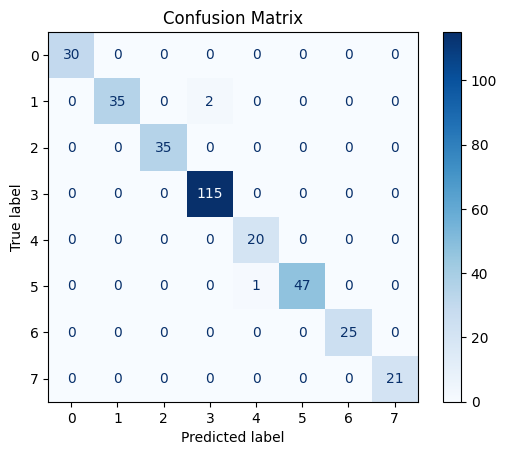

In [36]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = test_labels.numpy() if isinstance(test_labels, torch.Tensor) else test_labels
pred_labels = predicted_labels.numpy() if isinstance(predicted_labels, torch.Tensor) else predicted_labels

# confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Save model state_dict
torch.save(model.state_dict(), 'models/common_intents/intent_model.pt')

# Save tokenizer
roberta_tokenizer.save_pretrained('models/common_intents/intent_tokenizer')

# Save model state_dict
torch.save(model.state_dict(), '../ui/services/intent_handlers/models/common_intents/intent_tokenizer')
# Save tokenizer
roberta_tokenizer.save_pretrained('../ui/services/intent_handlers/models/common_intents/intent_tokenizer')

RuntimeError: File ../ui/services/intent_handlers/models/common_intents/intent_tokenizer cannot be opened.

In [32]:
def predict_intents(sentence, model, tokenizer, tense_labels, device):
    # Move model and tokenizer to the specified device
    model = model.to(device)
    tokenizer = tokenizer
    
    # Tokenize the sentence
    encoded_sentence = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        # Forward pass
        logits = model(encoded_sentence['input_ids'], encoded_sentence['attention_mask'])
        predicted_label = torch.argmax(logits, dim=1).item()
    
    # Get the predicted tense label
    predicted_intent = [k for k, v in tense_labels.items() if v == predicted_label][0]
    
    return predicted_intent

# Specify the device (e.g., 'cuda', 'mps' for GPU or 'cpu' for CPU)
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
sentence_to_predict = """
hello
"""
predicted_intent = predict_intents(sentence_to_predict, model, roberta_tokenizer, intents, device)
print(f"The predicted whisper intent for the sentence is: {predicted_intent}")


The predicted whisper intent for the sentence is: Greet
